<h1 style="text-align:center;">Integrate experimental Ala-scan / X-scan data with AF3 models</h1>

In [244]:
import glob
import os
import pandas as pd
import pickle
import numpy as np

from anarci import anarci
from Bio.PDB import PDBParser, NeighborSearch, PDBIO, Superimposer, MMCIFParser
from Bio.SeqUtils import seq1

import matplotlib.pyplot as plt
import seaborn as sns

# Infer TCR sequence

In [28]:
# Construct lookup table
anno_dir = '/Users/roessner/Documents/PostDoc/Data/MixTCRviz/data_raw/HomoSapiens' # full sequences for VJ-segments
ref_csvs = glob.glob(f'{anno_dir}/*.csv')
ref_csvs.sort()

ref_tables = {}

for file in ref_csvs:
    name = os.path.basename(file).replace('.csv', '')  # e.g. TRAV
    df = pd.read_csv(file)
    df['full_clean'] = df['full'].str.replace(r'[-*]', '', regex=True)
    ref_tables[name] = df

lookup = {}

for gene_type, df in ref_tables.items():
    df = df.set_index('Unnamed: 0')
    
    lookup[gene_type] = {
        'full': df['full_clean'].to_dict(),
        'cdr3': df['CDR3'].to_dict()
    }

def reconstruct_chain(v_gene, j_gene, observed_cdr3, v_type, j_type):
    v_full = lookup[v_type]['full'][v_gene]
    v_ref_cdr3 = lookup[v_type]['cdr3'][v_gene]

    j_full = lookup[j_type]['full'][j_gene]
    j_ref_cdr3 = lookup[j_type]['cdr3'][j_gene]

    v_clean = v_full[:-len(v_ref_cdr3)]
    j_clean = j_full[len(j_ref_cdr3):]
    
    return v_clean + observed_cdr3 + j_clean

In [91]:
topdir = '../260202_YF-modes/data_julien'
batches = ['LAU5013/YF_LAU5013_sc_WT', 'Public_Data/YF_public_pairedData_20251010']

threshold = 0.5

lst=[]
for batch in batches:
    batch_short = batch.split('/')[0]
    csv_file = glob.glob(f'{topdir}/{batch}/*.csv')[0]
    df = pd.read_csv(csv_file)
    df = df[(df["TEMPOproblem"].isna()) & (df['AF3_iptm_pair_mean'] > threshold)]
    df['batch'] = batch_short
    lst.append(df)

df = pd.concat(lst)
df = df[['id', 'batch', 'cdr1_TRA', 'cdr2_TRA', 'cdr3_TRA', 'cdr1_TRB', 'cdr2_TRB', 'cdr3_TRB', 'TRAV', 'TRAJ', 'TRBV', 'TRBJ']]

# annotate cluster
df_clusters = pd.read_csv('../260202_YF-modes/pca_CDR1A_cluster.csv')[['PDB', 'batch','cluster']]
df_clusters = df_clusters.rename(columns={'PDB':'id'})
df = pd.merge(df, df_clusters, on=['id', 'batch'])

# infer full TCR sequence
df['TRA_full'] = df.apply(
    lambda row: reconstruct_chain(
        row['TRAV'], row['TRAJ'], row['cdr3_TRA'],
        'TRAV', 'TRAJ'
    ),
    axis=1
)

df['TRB_full'] = df.apply(
    lambda row: reconstruct_chain(
        row['TRBV'], row['TRBJ'], row['cdr3_TRB'],
        'TRBV', 'TRBJ'
    ),
    axis=1
)

df.to_csv('AF_models_high_conf.csv', index=False)


# Align CDR loops based on IMGT numbering

In [235]:
def imgt_number_sequence(seq, chain_type="A"):
    """
    Number a full TCR chain sequence using IMGT via ANARCI.
    chain_type: 'A' = alpha, 'B' = beta
    Returns a dictionary: IMGT_position -> amino acid
    """
    results = anarci(
        sequences=[("query", seq)],
        scheme="imgt",
        assign_germline=True)  # for alpha
    
    numbering = results[0][0][0][0]  # list of ((pos, ins), aa)

    imgt_map = {}

    for ((pos, ins), aa) in numbering:
        if aa != "-":
            key = f"{pos}{ins.strip()}" if ins.strip() else str(pos)
            imgt_map[key] = aa

    return imgt_map


def extract_cdr_positions(imgt_map, start, end):
    """
    Extract residues within a CDR range.
    Handles insertions like 111A, 111B
    """
    cdr_positions = {}
    for key, aa in imgt_map.items():
        numeric = int(''.join(filter(str.isdigit, key)))
        if start <= numeric <= end:
            cdr_positions[key] = aa
    return cdr_positions

In [236]:
# cdr loops according to imgt convention
cdr1_alpha = (27, 38)
cdr2_alpha = (56, 65)
cdr3_alpha = (104, 118)

cdr1_beta = (27, 38)
cdr2_beta = (56, 65)
cdr3_beta = (104, 118)

df = pd.read_csv('AF_models_high_conf.csv')

cdr_results = {}

for _, row in df.iterrows():
    tcr_id = f'{row['id']}.{row['batch']}'
    # Alpha chain
    alpha_map = imgt_number_sequence(row['TRA_full'], chain_type='A')
    cdr1_alpha_map = extract_cdr_positions(alpha_map, *cdr1_alpha)
    cdr2_alpha_map = extract_cdr_positions(alpha_map, *cdr2_alpha)
    cdr3_alpha_map = extract_cdr_positions(alpha_map, *cdr3_alpha)

    # Beta chain
    beta_map = imgt_number_sequence(row['TRB_full'], chain_type='B')
    cdr1_beta_map = extract_cdr_positions(beta_map, *cdr1_beta)
    cdr2_beta_map = extract_cdr_positions(beta_map, *cdr2_beta)
    cdr3_beta_map = extract_cdr_positions(beta_map, *cdr3_beta)

    # correct anarci mistakes
    if row['TRAV'] == 'TRAV12-1':
        cdr2_alpha_map = {'56': 'V', '57': 'Y', '58': 'S', '63': 'S', '64': 'G', '65': 'N'}
    elif row['TRAV'] == 'TRAV40':
        cdr2_alpha_map = {'56': 'E', '57': 'T', '64': 'M', '65': 'E'}

    # Store
    cdr_results[tcr_id] = {
        "cdr1_TRA": cdr1_alpha_map,
        "cdr2_TRA": cdr2_alpha_map,
        "cdr3_TRA": cdr3_alpha_map,
        "cdr1_TRB": cdr1_beta_map,
        "cdr2_TRB": cdr2_beta_map,
        "cdr3_TRB": cdr3_beta_map,
    }

# build aligned dataframe
all_positions = set()
for tcr_id, cdr_dict in cdr_results.items():
    for cdr_name, cdr_map in cdr_dict.items():
        all_positions.update([(cdr_name, pos) for pos in cdr_map.keys()])

# Sort positions numerically + insertion letters
def imgt_sort_key(x):
    cdr_name, pos = x
    num = int(''.join(filter(str.isdigit, pos)))
    ins = ''.join(filter(str.isalpha, pos))
    return (cdr_name, num, ins)

all_positions = sorted(all_positions, key=imgt_sort_key)

# Create final dataframe
final_df = pd.DataFrame(index=cdr_results.keys(), columns=pd.MultiIndex.from_tuples(all_positions))

for tcr_id, cdr_dict in cdr_results.items():
    for cdr_name, cdr_map in cdr_dict.items():
        for pos, aa in cdr_map.items():
            final_df.loc[tcr_id, (cdr_name, pos)] = aa

final_df.to_csv('cdr_imgt_aligned.csv')
final_df


cdr1_TRA                       cdr1_TRB        ...  \
                          27 28 29   30   36 37 38       27 28 29  ...   
tcr0001.LAU5013            D  R  G  NaN    S  Q  S        L  G  H  ...   
tcr0005.LAU5013            D  R  G  NaN    S  Q  S        M  N  H  ...   
tcr0008.LAU5013            D  R  G  NaN    S  Q  S        D  F  Q  ...   
tcr0010.LAU5013            N  S  A  NaN    S  Q  S        L  G  H  ...   
tcr0014.LAU5013            D  R  G  NaN    S  Q  S        S  G  D  ...   
...                      ... .. ..  ...  ... .. ..      ... .. ..  ...   
tcr0384.Public_Data        T  S  I  NaN  NaN  N  N        S  G  D  ...   
tcr0385.Public_Data        D  R  G  NaN    S  Q  S        S  G  H  ...   
tcr0386.Public_Data        S  V  F  NaN  NaN  S  S        S  G  H  ...   
tcr0387.Public_Data        D  R  G  NaN    S  Q  S        L  N  H  ...   
tcr0388.Public_Data        D  R  G  NaN    S  Q  S        M  N  H  ...   

                    cdr3_TRB                                         
                         112 112A 112B 112C 113 114 115 116 117 118  
tcr0001.LAU5013            G    G    G  NaN   A   D   T   Q   Y   F  
tcr0005.LAU5013            G  NaN  NaN  NaN   A   Y   E   Q   Y   F  
tcr0008.LAU5013            G  NaN  NaN  NaN   T   D   T   Q   Y   F  
tcr0010.LAU5013            G    G  NaN  NaN   A   Y   E   Q   Y   F  
tcr0014.LAU5013            G  NaN  NaN  NaN   S   Y   E   Q   Y   F  
...                      ...  ...  ...  ...  ..  ..  ..  ..  ..  ..  
tcr0384.Public_Data        F  NaN  NaN  NaN   Y   N   E   Q   F   F  
tcr0385.Public_Data        P    G  NaN  NaN   A   G   E   L   F   F  
tcr0386.Public_Data        Q    G  NaN  NaN   Y   N   G   Y   T   F  
tcr0387.Public_Data        G  NaN  NaN  NaN   A   Y   E   Q   Y   F  
tcr0388.Public_Data        I  NaN  NaN  NaN   A   Y   E   Q   Y   F  

[720 rows x 67 columns]

# Infer structure-based residue index

In [219]:
def extract_cdr_resids(pdb_path, cdr_dict, chain_map={"TRA":"A","TRB":"B"}):
    """
    Extract residue id of CDRs based on the respective sequences.
    """
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("pdb", pdb_path)
    
    cdr_resids = {}
    for cdr_name, cdr_seq in cdr_dict.items():
        # get tcr chain
        chain_id = chain_map[cdr_name.split('_')[-1]]
        chain_obj = structure[0][chain_id]

        # Get all residues with C-alpha
        residues = [res for res in chain_obj if res.id[0] == " " and "CA" in res]

        # Convert 3-letter PDB codes to 1-letter
        seq = "".join([seq1(res.get_resname()) for res in residues])
 
        # find CDR sequence in the chain sequence
        L = len(cdr_seq)
        start_idx = seq.find(cdr_seq)
        if start_idx == -1:
            print(f"Warning: CDR {cdr_name} sequence not found in chain {chain_id} of {pdb_path}")
            return None
        
        end_idx = start_idx + L
        
        # extract cdr resids
        resids = np.array([res.get_id()[1] for res in residues[start_idx:end_idx]])
        cdr_resids[cdr_name] = resids

    return cdr_resids

from Bio.PDB import PDBParser, NeighborSearch
import numpy as np

def compute_cdr_min_distances(pdb_file, cdr_resids, chain_map, pmhc_chains=("A","E")):
    """
    Extract minimal distances between CDR residues and pMHC.
    """
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("tcr", pdb_file)
    
    # Collect all atoms of pMHC chains
    pmhc_atoms = []
    for chain_id in pmhc_chains:
        chain = structure[0][chain_id]
        pmhc_atoms.extend([atom for atom in chain.get_atoms() if atom.element != "H"])
    ns = NeighborSearch(pmhc_atoms)
    
    cdr_distances = {}
    
    for cdr, res_nums in cdr_resids.items():
        # figure out which TCR chain this cdr belongs to
        if "TRA" in cdr:
            tcr_chain_id = chain_map["TRA"]
        else:
            tcr_chain_id = chain_map["TRB"]
        
        chain = structure[0][tcr_chain_id]
        distances = []
        
        for res_num in res_nums:
            try:
                res = chain[(' ', res_num, ' ')]  # ('HETATM flag', resid, insertion)
            except KeyError:
                distances.append(np.nan)
                continue
            
            # get all heavy atoms
            res_atoms = [atom for atom in res.get_atoms() if atom.element != "H"]
            
            # compute min distance of this residue to pMHC atoms
            if res_atoms:
                min_dist = min(atom - pmhc_atom for atom in res_atoms for pmhc_atom in pmhc_atoms)
                distances.append(min_dist)
            else:
                distances.append(np.nan)
        
        cdr_distances[cdr] = np.array(distances)
    
    return cdr_distances


def replace_residues_with_distances(df_aligned, cdr_min_distances, tcr_index):
    """
    Annotate aligned cdr loops with minimal distance values.
    """
    
    for cdr in cdr_min_distances:
        if cdr not in df_aligned.columns.levels[0]:
            continue
        
        # All IMGT positions for this CDR
        cdr_cols = df_aligned[cdr].columns
        
        # Row slice for this CDR
        row_vals = df_aligned.loc[tcr_index, (cdr, slice(None))]
        
        # Count non-NaN positions in the alignment
        n_non_nan = row_vals.notna().sum()
        
        # Number of distances
        n_distances = len(cdr_min_distances[cdr])

        if n_distances != n_non_nan:
            raise ValueError(
                f"Mismatch for {tcr_index} {cdr}: "
                f"{n_non_nan} non-NaN positions in alignment, "
                f"but {n_distances} distances provided"
            )

        # Replace only non-NaN letters with distances
        new_row = row_vals.copy()
        distance_idx = 0

        for col in cdr_cols:
            if pd.isna(row_vals[cdr][col]):
                continue  # keep NaN
            new_row[cdr][col] = cdr_min_distances[cdr][distance_idx]
            distance_idx += 1

        # Assign back
        df_aligned.loc[tcr_index, (cdr, slice(None))] = new_row
        
    return df_aligned

    

In [241]:
topdir = '../260202_YF-modes/data_julien'
batches = {'LAU5013': 'LAU5013/YF_LAU5013_sc_WT', 
           'Public_Data':'Public_Data/YF_public_pairedData_20251010'}

df = pd.read_csv('AF_models_high_conf.csv')

df_aligned = pd.read_csv('cdr_imgt_aligned.csv', header=[0,1], index_col=0)

for idx, row in df.iterrows():
    tcr_id = row['id']
    batch_short = row['batch']

    pdb_file = f'{topdir}/{batches[batch_short]}/model_pdb_align_exp/{tcr_id}.pdb'
    chain_map={"TRA":"B","TRB":"C"}

    # get residue ids
    cdr_dict = {cdr: str(row[cdr]).upper() for cdr in ["cdr1_TRA","cdr2_TRA","cdr3_TRA","cdr1_TRB","cdr2_TRB","cdr3_TRB"]}
    cdr_resids = extract_cdr_resids(pdb_file, cdr_dict, chain_map)

    # get pMHC distance
    cdr_min_distances = compute_cdr_min_distances(pdb_file, cdr_resids, chain_map)

    # get aligned dataframe
    df_aligned = replace_residues_with_distances(df_aligned, cdr_min_distances, f'{tcr_id}.{batch_short}')

df_aligned.to_csv('cdr_imgt_aligned_min_dist.csv')
    

/var/folders/2v/m8p5rbh538sgyrgvrcyb210h0000gn/T/ipykernel_56058/905012013.py:121: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  new_row[cdr][col] = cdr_min_distances[cdr][distance_idx]
/var/folders/2v/m8p5rbh538sgyrgvrcyb210h0000gn/T/ipyker

# Visualization

/var/folders/2v/m8p5rbh538sgyrgvrcyb210h0000gn/T/ipykernel_56058/2496543265.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 1 if x < 5 else 0)


                    cdr1_TRA                cdr1_TRB           ... cdr3_TRB  \
                          27 28 29 36 37 38       27 28 29 36  ...      110   
tcr0001.LAU5013            0  1  1  1  1  1        0  0  0  0  ...        0   
tcr0005.LAU5013            0  1  1  0  1  1        0  0  0  0  ...        1   
tcr0008.LAU5013            0  1  1  1  1  1        0  0  0  0  ...        1   
tcr0010.LAU5013            0  1  1  1  1  1        0  0  0  0  ...        1   
tcr0014.LAU5013            0  1  1  1  1  1        0  0  0  0  ...        1   
...                      ... .. .. .. .. ..      ... .. .. ..  ...      ...   
tcr0384.Public_Data        0  0  0  0  1  1        0  0  0  0  ...        0   
tcr0385.Public_Data        1  1  1  0  1  1        0  0  0  0  ...        1   
tcr0386.Public_Data        0  1  0  0  1  0        0  0  0  0  ...        1   
tcr0387.Public_Data        0  1  1  1  1  1        0  0  0  0  ...        0   
tcr0388.Public_Data        0  1  1  1  1  1        0

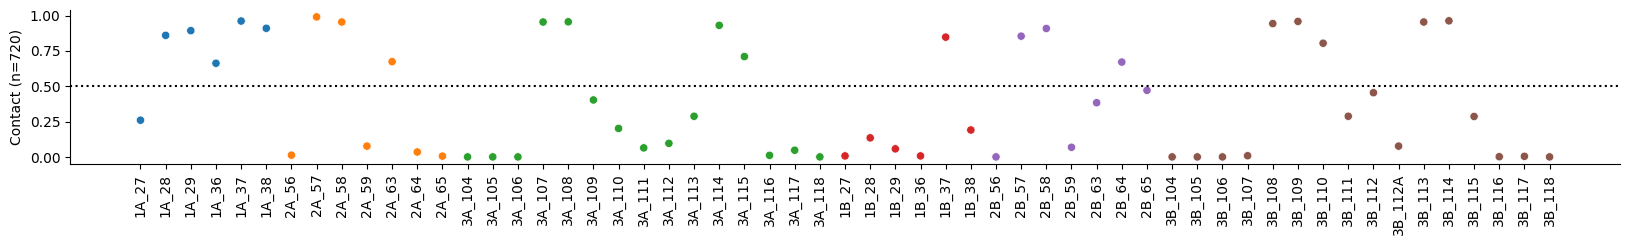

In [386]:
df = pd.read_csv('cdr_imgt_aligned_min_dist.csv', header=[0,1], index_col=0)
# Keep columns that have at least 5% non-NaN values
df = df.dropna(axis=1, thresh=int(0.05 * len(df)))

# convert distances to contacts
df = df.applymap(lambda x: 1 if x < 5 else 0)
print(df)
new_cols = []
for cdr_name, pos in df.columns:
    cdr_split = cdr_name.split('_')
    new_col = f'{cdr_split[0][-1]}{cdr_split[1][-1]}_{pos}'
    new_cols.append(new_col)

df.columns = new_cols
df_long = df.reset_index().melt(
    id_vars = 'index',
    var_name='position',
    value_name='contact'
)

df_long = df_long.rename(columns={'index':'tcr_id'})

# compute mean across all samples
df_mean = df_long.groupby('position')['contact'].mean().reset_index()

df_mean['cdr'] = [x.split('_')[0] for x in df_mean['position']]
cdr_order = ["1A", "2A", "3A", "1B", "2B", "3B"]
df_mean['cdr'] = pd.Categorical(df_mean['cdr'], categories=cdr_order, ordered=True)
df_mean = df_mean.sort_values(by=['cdr', 'position']).reset_index(drop=True)

fig, ax = plt.subplots(1,1,figsize=(20,2))
sns.scatterplot(df_mean, x='position', y='contact', hue='cdr', ax=ax, legend=False)
ax.tick_params(axis='x', rotation=90)
ax.set_xlabel('')
ax.set_ylabel(f'Contact (n={len(df)})')
ax.axhline(0.5, color='black', linestyle=':')
sns.despine()

/var/folders/2v/m8p5rbh538sgyrgvrcyb210h0000gn/T/ipykernel_56058/270293522.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 1 if x < 5 else 0)
/var/folders/2v/m8p5rbh538sgyrgvrcyb210h0000gn/T/ipykernel_56058/270293522.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 1 if x < 5 else 0)


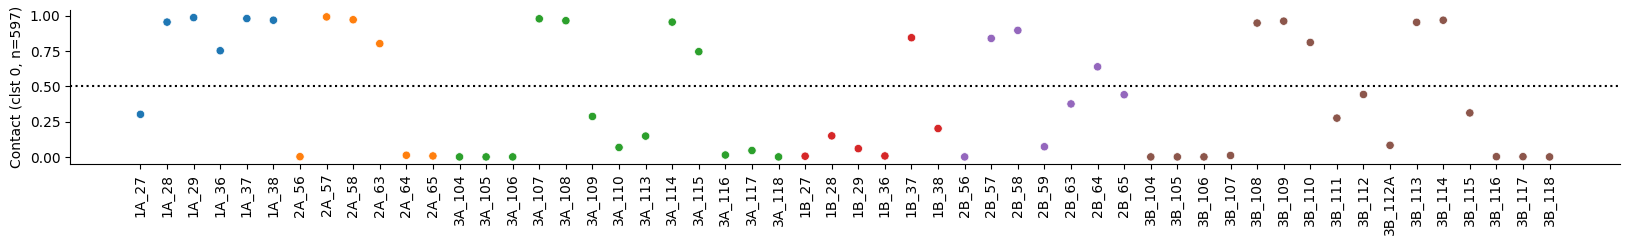

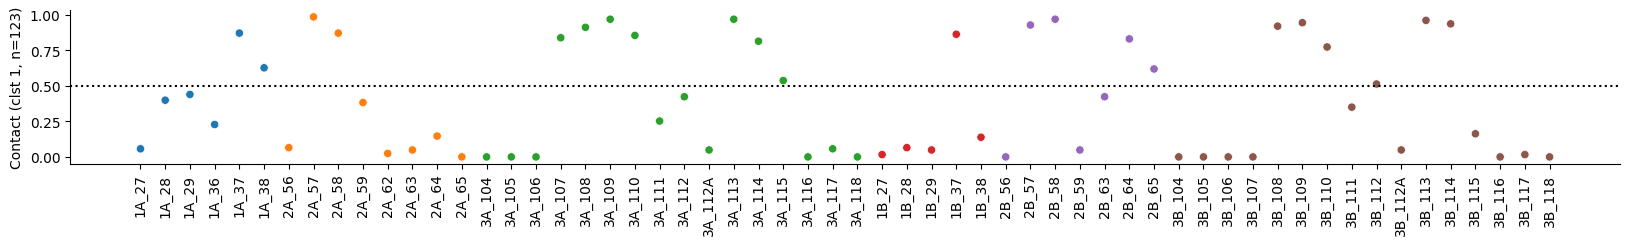

In [387]:
clusters = [0,1]

for cluster in clusters:
    df_anno = pd.read_csv('AF_models_high_conf.csv')
    df_anno['tcr_id'] = df_anno['id'].astype(str) + '.' + df_anno['batch'].astype(str)
    df_anno = df_anno[df_anno['cluster'] == cluster]
    tcr_ids = df_anno['tcr_id'].values
    
    df = pd.read_csv('cdr_imgt_aligned_min_dist.csv', header=[0,1], index_col=0)
    df = df.loc[df.index.isin(tcr_ids)]

    # Keep columns that have at least 5% non-NaN values
    df = df.dropna(axis=1, thresh=int(0.05 * len(df)))

    # convert distances to contacts
    df = df.applymap(lambda x: 1 if x < 5 else 0)

    new_cols = []
    for cdr_name, pos in df.columns:
        cdr_split = cdr_name.split('_')
        new_col = f'{cdr_split[0][-1]}{cdr_split[1][-1]}_{pos}'
        new_cols.append(new_col)

    df.columns = new_cols
    df_long = df.reset_index().melt(
        id_vars = 'index',
        var_name='position',
        value_name='contact'
    )

    df_long = df_long.rename(columns={'index':'tcr_id'})

    # compute mean
    df_mean = df_long.groupby('position')['contact'].mean().reset_index()

    df_mean['cdr'] = [x.split('_')[0] for x in df_mean['position']]
    cdr_order = ["1A", "2A", "3A", "1B", "2B", "3B"]
    df_mean['cdr'] = pd.Categorical(df_mean['cdr'], categories=cdr_order, ordered=True)
    df_mean = df_mean.sort_values(by=['cdr', 'position']).reset_index(drop=True)

    fig, ax = plt.subplots(1,1,figsize=(20,2))
    sns.scatterplot(df_mean, x='position', y='contact', hue='cdr', ax=ax, legend=False)
    ax.tick_params(axis='x', rotation=90)
    ax.set_xlabel('')
    ax.set_ylabel(f'Contact (clst {cluster}, n={len(df)})')
    ax.axhline(0.5, color='black', linestyle=':')
    sns.despine()

# Correlate with Alascan data

In [498]:
# find template clonotype
df_anno = pd.read_csv('AF_models_high_conf.csv')
df_anno['tcr_id'] = df_anno['id'].astype(str) + '.' + df_anno['batch'].astype(str)

df_anno = df_anno[(df_anno['TRAV'] == 'TRAV12-2') & (df_anno['TRAJ'] == 'TRAJ30') & (df_anno['TRBV'] == 'TRBV28')& (df_anno['TRBJ'] == 'TRBJ2-7')]
df_anno = df_anno[df_anno['cdr3_TRB'].str.len() == 13]
tcr_id = df_anno['tcr_id'].values[0]

# positions for experimentally tested TCR
df_aligned = pd.read_csv('cdr_imgt_aligned_min_dist.csv', header=[0,1], index_col=0)
df_aligned = df_aligned.loc[tcr_id].dropna()

aligned_positions = df_aligned.index

lst = []
df_cols = aligned_positions.to_frame(index=False, name=['CDR', 'position'])
for name, group in df_cols.groupby('CDR'):
    if (name == 'cdr3_TRA') | (name == 'cdr3_TRB'):
        group = group.iloc[1:-3] # remove positions that where not experimentally tested
        lst.append(group)
    else:
        lst.append(group)
        
df_cols = pd.concat(lst)
df_cols['position'] = df_cols['CDR'].str.split('_').str[0].str[-1] + df_cols['CDR'].str.split('_').str[1].str[-1] + '_' + df_cols['position'].astype(str)

# experimental data
df_exp = pd.read_csv('YF-AlaScan.csv', sep=';')
df_exp = df_exp[df_exp['Name'] != 'template']
df_exp['CDR'] = df_exp['Name'].str.split('_').str[0]

# add position assignement (coorect order)
df_exp['position'] = df_cols['position'].values
df_exp['Results_mod'] = (100 - df_exp['Results']) / 100
df_exp.to_csv('YF-AlaScan_anno_aligned_pos.csv', index=False)
df_exp

Name                                                TRA  \
1    CDR1A_D1A  QKEVEQNSGPLSVPEGAIASLNCTYSARGSQSFFWYRQYSGKSPEL...   
2    CDR1A_R2A  QKEVEQNSGPLSVPEGAIASLNCTYSDAGSQSFFWYRQYSGKSPEL...   
3    CDR1A_G3A  QKEVEQNSGPLSVPEGAIASLNCTYSDRASQSFFWYRQYSGKSPEL...   
4    CDR1A_S4A  QKEVEQNSGPLSVPEGAIASLNCTYSDRGAQSFFWYRQYSGKSPEL...   
5    CDR1A_Q5A  QKEVEQNSGPLSVPEGAIASLNCTYSDRGSASFFWYRQYSGKSPEL...   
6    CDR1A_S6A  QKEVEQNSGPLSVPEGAIASLNCTYSDRGSQAFFWYRQYSGKSPEL...   
7    CDR2A_I1A  QKEVEQNSGPLSVPEGAIASLNCTYSDRGSQSFFWYRQYSGKSPEL...   
8    CDR2A_Y2A  QKEVEQNSGPLSVPEGAIASLNCTYSDRGSQSFFWYRQYSGKSPEL...   
9    CDR2A_S3A  QKEVEQNSGPLSVPEGAIASLNCTYSDRGSQSFFWYRQYSGKSPEL...   
10   CDR2A_N4A  QKEVEQNSGPLSVPEGAIASLNCTYSDRGSQSFFWYRQYSGKSPEL...   
11   CDR2A_G5A  QKEVEQNSGPLSVPEGAIASLNCTYSDRGSQSFFWYRQYSGKSPEL...   
12   CDR2A_D6A  QKEVEQNSGPLSVPEGAIASLNCTYSDRGSQSFFWYRQYSGKSPEL...   
13   CDR3A_A2A  QKEVEQNSGPLSVPEGAIASLNCTYSDRGSQSFFWYRQYSGKSPEL...   
14   CDR3A_V3A  QKEVEQNSGPLSVPEGAIASLNCTYSDRGSQSFFWYRQYSGKSPEL...   
15   CDR3A_G4A  QKEVEQNSGPLSVPEGAIASLNCTYSDRGSQSFFWYRQYSGKSPEL...   
16   CDR3A_D5A  QKEVEQNSGPLSVPEGAIASLNCTYSDRGSQSFFWYRQYSGKSPEL...   
17   CDR3A_D6A  QKEVEQNSGPLSVPEGAIASLNCTYSDRGSQSFFWYRQYSGKSPEL...   
18   CDR3A_K7A  QKEVEQNSGPLSVPEGAIASLNCTYSDRGSQSFFWYRQYSGKSPEL...   
19   CDR1B_M1A  QKEVEQNSGPLSVPEGAIASLNCTYSDRGSQSFFWYRQYSGKSPEL...   
20   CDR1B_D2A  QKEVEQNSGPLSVPEGAIASLNCTYSDRGSQSFFWYRQYSGKSPEL...   
21   CDR1B_H3A  QKEVEQNSGPLSVPEGAIASLNCTYSDRGSQSFFWYRQYSGKSPEL...   
22   CDR1B_E4A  QKEVEQNSGPLSVPEGAIASLNCTYSDRGSQSFFWYRQYSGKSPEL...   
23   CDR1B_N5A  QKEVEQNSGPLSVPEGAIASLNCTYSDRGSQSFFWYRQYSGKSPEL...   
24   CDR2B_S1A  QKEVEQNSGPLSVPEGAIASLNCTYSDRGSQSFFWYRQYSGKSPEL...   
25   CDR2B_Y2A  QKEVEQNSGPLSVPEGAIASLNCTYSDRGSQSFFWYRQYSGKSPEL...   
26   CDR2B_D3A  QKEVEQNSGPLSVPEGAIASLNCTYSDRGSQSFFWYRQYSGKSPEL...   
27   CDR2B_V4A  QKEVEQNSGPLSVPEGAIASLNCTYSDRGSQSFFWYRQYSGKSPEL...   
28   CDR2B_K5A  QKEVEQNSGPLSVPEGAIASLNCTYSDRGSQSFFWYRQYSGKSPEL...   
29   CDR2B_M6A  QKEVEQNSGPLSVPEGAIASLNCTYSDRGSQSFFWYRQYSGKSPEL...   
30   CDR3B_A2A  QKEVEQNSGPLSVPEGAIASLNCTYSDRGSQSFFWYRQYSGKSPEL...   
31   CDR3B_S3A  QKEVEQNSGPLSVPEGAIASLNCTYSDRGSQSFFWYRQYSGKSPEL...   
32   CDR3B_T4A  QKEVEQNSGPLSVPEGAIASLNCTYSDRGSQSFFWYRQYSGKSPEL...   
33   CDR3B_P5A  QKEVEQNSGPLSVPEGAIASLNCTYSDRGSQSFFWYRQYSGKSPEL...   
34   CDR3B_Q6A  QKEVEQNSGPLSVPEGAIASLNCTYSDRGSQSFFWYRQYSGKSPEL...   
35   CDR3B_T7A  QKEVEQNSGPLSVPEGAIASLNCTYSDRGSQSFFWYRQYSGKSPEL...   
36   CDR3B_A8A  QKEVEQNSGPLSVPEGAIASLNCTYSDRGSQSFFWYRQYSGKSPEL...   
37   CDR3B_Y9A  QKEVEQNSGPLSVPEGAIASLNCTYSDRGSQSFFWYRQYSGKSPEL...   
38  CDR3B_E10A  QKEVEQNSGPLSVPEGAIASLNCTYSDRGSQSFFWYRQYSGKSPEL...   

                                                  TRB               TRAV  \
1   DVKVTQSSRYLVKRTGEKVFLECVQDMDHENMFWYRQDPGLGLRLI...  TRAV12-2_modified   
2   DVKVTQSSRYLVKRTGEKVFLECVQDMDHENMFWYRQDPGLGLRLI...  TRAV12-2_modified   
3   DVKVTQSSRYLVKRTGEKVFLECVQDMDHENMFWYRQDPGLGLRLI...  TRAV12-2_modified   
4   DVKVTQSSRYLVKRTGEKVFLECVQDMDHENMFWYRQDPGLGLRLI...  TRAV12-2_modified   
5   DVKVTQSSRYLVKRTGEKVFLECVQDMDHENMFWYRQDPGLGLRLI...  TRAV12-2_modified   
6   DVKVTQSSRYLVKRTGEKVFLECVQDMDHENMFWYRQDPGLGLRLI...  TRAV12-2_modified   
7   DVKVTQSSRYLVKRTGEKVFLECVQDMDHENMFWYRQDPGLGLRLI...  TRAV12-2_modified   
8   DVKVTQSSRYLVKRTGEKVFLECVQDMDHENMFWYRQDPGLGLRLI...  TRAV12-2_modified   
9   DVKVTQSSRYLVKRTGEKVFLECVQDMDHENMFWYRQDPGLGLRLI...  TRAV12-2_modified   
10  DVKVTQSSRYLVKRTGEKVFLECVQDMDHENMFWYRQDPGLGLRLI...  TRAV12-2_modified   
11  DVKVTQSSRYLVKRTGEKVFLECVQDMDHENMFWYRQDPGLGLRLI...  TRAV12-2_modified   
12  DVKVTQSSRYLVKRTGEKVFLECVQDMDHENMFWYRQDPGLGLRLI...  TRAV12-2_modified   
13  DVKVTQSSRYLVKRTGEKVFLECVQDMDHENMFWYRQDPGLGLRLI...           TRAV12-2   
14  DVKVTQSSRYLVKRTGEKVFLECVQDMDHENMFWYRQDPGLGLRLI...           TRAV12-2   
15  DVKVTQSSRYLVKRTGEKVFLECVQDMDHENMFWYRQDPGLGLRLI...           TRAV12-2   
16  DVKVTQSSRYLVKRTGEKVFLECVQDMDHENMFWYRQDPGLGLRLI...           TRAV12-2   
17  DVKVTQSSRYLVKRTGEKVFLE

/var/folders/2v/m8p5rbh538sgyrgvrcyb210h0000gn/T/ipykernel_56058/3171254607.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 1 if x < 5 else 0)
/var/folders/2v/m8p5rbh538sgyrgvrcyb210h0000gn/T/ipykernel_56058/3171254607.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 1 if x < 5 else 0)


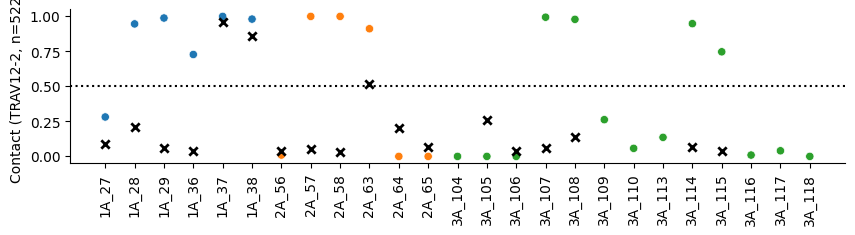

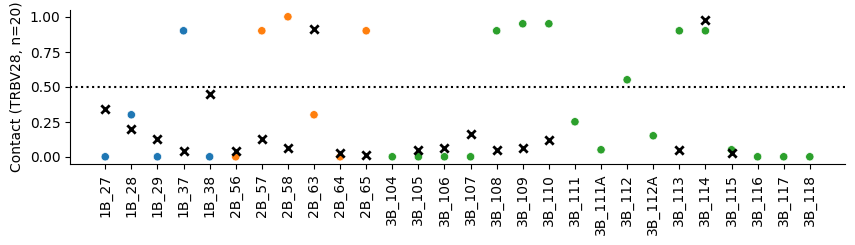

In [514]:
# experimental data
df_exp = pd.read_csv('YF-AlaScan_anno_aligned_pos.csv')[['position', 'Results_mod']]

clusters = ['TRAV12-2','TRBV28']

for cluster in clusters:
    df_anno = pd.read_csv('AF_models_high_conf.csv')
    df_anno['tcr_id'] = df_anno['id'].astype(str) + '.' + df_anno['batch'].astype(str)

    if cluster == 'TRAV12-2':
        df_anno = df_anno[df_anno['TRAV'] == cluster]
    else:
        df_anno = df_anno[df_anno['TRBV'] == cluster]
    tcr_ids = df_anno['tcr_id'].values
    
    df = pd.read_csv('cdr_imgt_aligned_min_dist.csv', header=[0,1], index_col=0)
    df = df.loc[df.index.isin(tcr_ids)]
    
    # Keep columns that have at least 5% non-NaN values
    df = df.dropna(axis=1, thresh=int(0.05 * len(df)))

    # convert distances to contacts
    df = df.applymap(lambda x: 1 if x < 5 else 0)

    new_cols = []
    for cdr_name, pos in df.columns:
        cdr_split = cdr_name.split('_')
        new_col = f'{cdr_split[0][-1]}{cdr_split[1][-1]}_{pos}'
        new_cols.append(new_col)

    df.columns = new_cols
    df_long = df.reset_index().melt(
        id_vars = 'index',
        var_name='position',
        value_name='contact'
    )

    df_long = df_long.rename(columns={'index':'tcr_id'})

    # compute mean
    df_mean = df_long.groupby('position')['contact'].mean().reset_index()
    df_mean['cdr'] = [x.split('_')[0] for x in df_mean['position']]
    if cluster == 'TRAV12-2':
        df_mean = df_mean[df_mean['position'].str.contains('A_')]
    else:
        df_mean = df_mean[df_mean['position'].str.contains('B_')]
    
    # add experimental data
    df_mean = pd.merge(df_mean, df_exp, on='position', how='left')

    fig, ax = plt.subplots(1,1,figsize=(10,2))
    sns.scatterplot(df_mean, x='position', y='contact', hue='cdr', ax=ax, legend=False)
    sns.scatterplot(df_mean, x='position', y='Results_mod', ax=ax, legend=False, color='black', marker='x', linewidth=2)
    ax.tick_params(axis='x', rotation=90)
    ax.set_xlabel('')
    ax.set_ylabel(f'Contact ({cluster}, n={len(df)})')
    ax.axhline(0.5, color='black', linestyle=':')
    sns.despine()


/var/folders/2v/m8p5rbh538sgyrgvrcyb210h0000gn/T/ipykernel_56058/3372617789.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 1 if x < 5 else 0)
/var/folders/2v/m8p5rbh538sgyrgvrcyb210h0000gn/T/ipykernel_56058/3372617789.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 1 if x < 5 else 0)


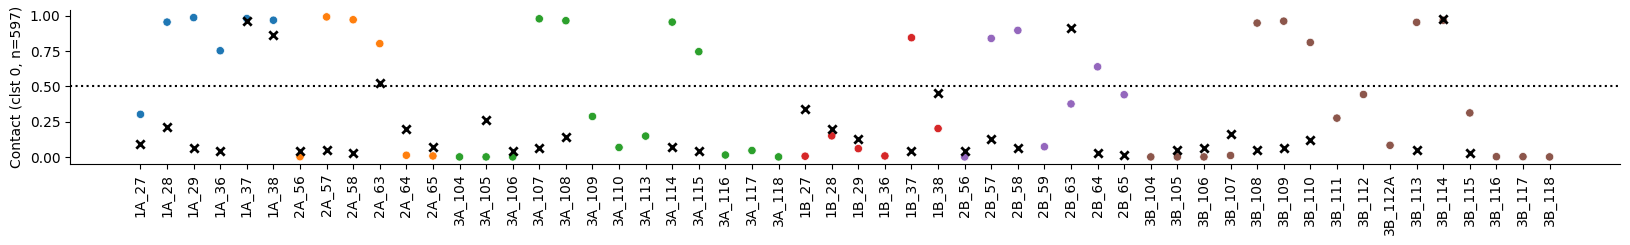

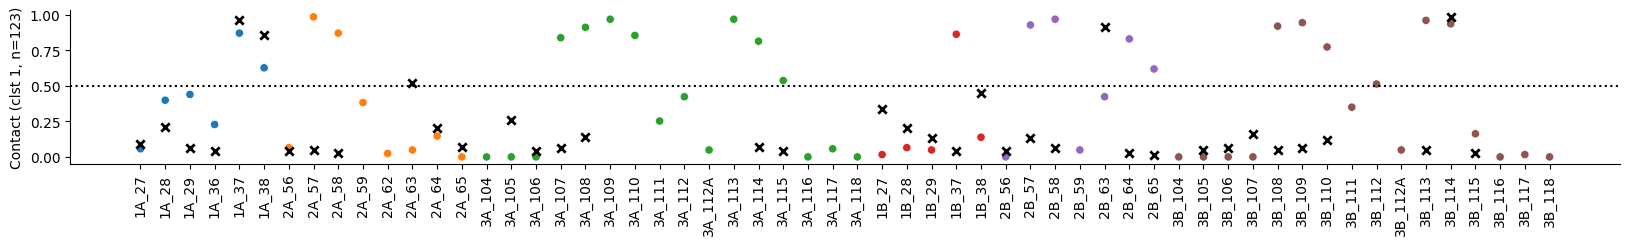

In [513]:
# experimental data
df_exp = pd.read_csv('YF-AlaScan_anno_aligned_pos.csv')[['position', 'Results_mod']]

clusters = [0,1]

for cluster in clusters:
    df_anno = pd.read_csv('AF_models_high_conf.csv')
    df_anno['tcr_id'] = df_anno['id'].astype(str) + '.' + df_anno['batch'].astype(str)
    df_anno = df_anno[df_anno['cluster'] == cluster]
    tcr_ids = df_anno['tcr_id'].values
    
    df = pd.read_csv('cdr_imgt_aligned_min_dist.csv', header=[0,1], index_col=0)
    df = df.loc[df.index.isin(tcr_ids)]

    # Keep columns that have at least 5% non-NaN values
    df = df.dropna(axis=1, thresh=int(0.05 * len(df)))

    # convert distances to contacts
    df = df.applymap(lambda x: 1 if x < 5 else 0)

    new_cols = []
    for cdr_name, pos in df.columns:
        cdr_split = cdr_name.split('_')
        new_col = f'{cdr_split[0][-1]}{cdr_split[1][-1]}_{pos}'
        new_cols.append(new_col)

    df.columns = new_cols
    df_long = df.reset_index().melt(
        id_vars = 'index',
        var_name='position',
        value_name='contact'
    )

    df_long = df_long.rename(columns={'index':'tcr_id'})

    # compute mean
    df_mean = df_long.groupby('position')['contact'].mean().reset_index()

    df_mean['cdr'] = [x.split('_')[0] for x in df_mean['position']]
    cdr_order = ["1A", "2A", "3A", "1B", "2B", "3B"]
    df_mean['cdr'] = pd.Categorical(df_mean['cdr'], categories=cdr_order, ordered=True)
    df_mean = df_mean.sort_values(by=['cdr', 'position']).reset_index(drop=True)

    # add experimental data
    df_mean = pd.merge(df_mean, df_exp, on='position', how='left')

    fig, ax = plt.subplots(1,1,figsize=(20,2))
    sns.scatterplot(df_mean, x='position', y='contact', hue='cdr', ax=ax, legend=False)
    sns.scatterplot(df_mean, x='position', y='Results_mod', ax=ax, legend=False, color='black', marker='x', linewidth=2)
    ax.tick_params(axis='x', rotation=90)
    ax.set_xlabel('')
    ax.set_ylabel(f'Contact (clst {cluster}, n={len(df)})')
    ax.axhline(0.5, color='black', linestyle=':')
    sns.despine()